# Surface water mass transformation (WMT) analysis using `xwmt`

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os

# Optional (loading to memory and plotting) 
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import calendar

In [2]:
print('numpy version',np.__version__,'\npandas version',pd.__version__,'\nxarray version',xr.__version__)

numpy version 1.22.4 
pandas version 1.4.3 
xarray version 2022.6.0


## Loading a dataset
Update `rootdir` with your own dataset's path. All relevant variables will be loaded into `ds` and the (static) grid data will be loaded into a separate dataset. Note that the time period (`tprd`) is `'201001-201412'` such that only the last five years of the CM4 historical run are used. In order to include more years, you can use wildchard `*` for `tprd` instead.

In [3]:
rootdir = '/data_cmip6/CMIP6'
activity_id = 'CMIP'
institution_id = 'NOAA-GFDL'
source_id = 'GFDL-CM4'
experiment_id = 'historical'
member_id = 'r1i1p1f1'
table_id = 'Omon'
grid_label = 'gn'
version = 'v20180701'
tprd = '201001-201412'
#tprd = '*'

ncdir = os.path.join(rootdir,activity_id,institution_id,source_id,experiment_id,member_id,table_id)

For surface WMT we only need the surface tracer fields (SST and SSS) and fluxes. See the list of variables with a description below. In this tutorial we are focusing on the total fluxes of heat and freshwater. `xwmt` also includes the calculations of WMT due to salt fluxes. However, the corresponding diagnostics (`sfdsi`) might not be available. The good news is that this is usually a minor term in the surface WMT calculation and can be set to zero (if not availalble). 
- `tos`: Sea Surface Temperature (units: degC)
> Temperature of upper boundary of the liquid ocean, including temperatures below sea-ice and floating ice shelves.
- `sos`: Sea Surface Salinity (units: 0.001) 
> Sea water salinity is the salt content of sea water, often on the Practical Salinity Scale of 1978. However, the unqualified term 'salinity' is generic and does not necessarily imply any particular method of calculation. The units of salinity are dimensionless and the units attribute should normally be given as 1e-3 or 0.001 i.e. parts per thousand. 
- `hfds`: Downward Heat Flux at Sea Water Surface (units: W m-2)
> This is the net flux of heat entering the liquid water column through its upper surface (excluding any "flux adjustment").
- `wfo`: Water Flux into Sea Water (units: kg m-2 s-1)
> Computed as the water flux into the ocean divided by the area of the ocean portion of the grid cell. This is the sum *wfonocorr* and *wfcorr*.
- `sfdsi`: Downward Sea Ice Basal Salt Flux (units: kg m-2 s-1)
> This field is physical, and it arises since sea ice has a nonzero salt content, so it exchanges salt with the liquid ocean upon melting and freezing.

In [4]:
variables = ['tos','sos','hfds','wfo','sfdsi']
#dss = []
ds = xr.Dataset()
for var in variables:
    filepath = os.path.join(ncdir,var,grid_label,version)
    filename = '_'.join([var,table_id,source_id,experiment_id,member_id,grid_label,tprd])+'.nc'
    
    if os.path.isdir(filepath):
        print('Loading',filename)
        #dss.append(xr.open_mfdataset(filepath+'/'+filename,use_cftime=True))
        ds[var] = xr.open_mfdataset(filepath+'/'+filename,use_cftime=True)[var]
    else:
        print('Path for',var,'does not exist. Skipping.')

Loading tos_Omon_GFDL-CM4_historical_r1i1p1f1_gn_201001-201412.nc
Loading sos_Omon_GFDL-CM4_historical_r1i1p1f1_gn_201001-201412.nc
Loading hfds_Omon_GFDL-CM4_historical_r1i1p1f1_gn_201001-201412.nc
Loading wfo_Omon_GFDL-CM4_historical_r1i1p1f1_gn_201001-201412.nc
Path for sfdsi does not exist. Skipping.


Besides the surface fields , `xwmt` also requires latitude, logitude and the cell area (`areacello`). We also will load the bathymetry (`deptho`) and ocean basin mask (`basin`) so we can subsample the datast by ocean depth and basins.

In [5]:
grid = []
for var in ['areacello','deptho','basin']:
    filepath = os.path.join(ncdir.replace(table_id,'Ofx'),var,grid_label,version)
    filename = '_'.join([var,'Ofx',source_id,experiment_id,member_id,grid_label])+'.nc'
    
    if os.path.isdir(filepath):
        print('Loading',filename)
        grid.append(xr.open_mfdataset(filepath+'/'+filename,use_cftime=True))
    else:
        print('Path for',var,'does not exist. Skipping.')

Loading areacello_Ofx_GFDL-CM4_historical_r1i1p1f1_gn.nc
Loading deptho_Ofx_GFDL-CM4_historical_r1i1p1f1_gn.nc
Loading basin_Ofx_GFDL-CM4_historical_r1i1p1f1_gn.nc


Now we can combine the variable and grid info and set the dimension and coordinate names to a common standard. In the case for CM4, there are inconsistencies in the static file for `arecello` (the dimension names are not common CMOR standard). So we need to rename the dimensions first in order to have consistency among the loaded data arrays before combining them.

In [7]:
#ds = xr.merge(dss+grid[1:])
ds = xr.merge([ds, xr.merge(grid[1:])])

# Area needs to be loaded seperately after renaming MOM6-specific dimension names (xh, yh) 
ds['areacello'] = grid[0].areacello.rename({'xh': 'x', 'yh': 'y'})

`xwmt` requires a land mask with the name `wet` that has values of 1 for ocean and 0 for land. In  most cases, model output fields already have the land masked out. Having a seperate land mask helps to avoid any potential issues due to various ways of defining missing values (e.g., -999 vs. 0 vs. NaN). Here we use the bathymetry file `deptho` to define land where `deptho` is NaN. It is recommended to check how land is defined in your model-specifc output and then generate `wet` accordingly.

In [8]:
# Create land mask "wet" from deptho
ds['wet'] = xr.where(~np.isnan(ds.deptho),1,0)
# wet is 1 for ocean and 0 for land

The wmt package expects a variable name `sfdsi` for the salt flux. In the case `sfdsi` is not available, we can create an array with all zeros having the same dimensions as the other flux fields (`hfds`, `wfo`). 

In [9]:
# Create an all-zero data array for sfdsi (when it is missing)
if not 'sfdsi' in ds:
    print('sfdsi is missing: Add all-zero field for sfdsi based on hfds')
    ds['sfdsi'] = xr.zeros_like(ds['hfds']).rename('sfdsi')
    # Remove all attributes
    ds['sfdsi'].attrs = {}

sfdsi is missing: Add all-zero field for sfdsi based on hfds


## Surface WMT using `swmt` class

The first step is to initialize the class by creating an object. This object includes all the calculations for surface WMT (`swmt`) and full 3D WMT (`wmt`). Since we use here surface fluxes, we will use the `swmt` class.

In [10]:
from xwmt.swmt import swmt

The `swmt` class object includes multiple functions to look at the relevant data. The most common function is `.G()` which gives you the WMT along $\lambda$ (i.e., $G(\lambda)$). Here, we need to define $\lambda$. For example, 'theta' for potential temperature ($\theta$) or 'sigma0' for potential density referenced at 0 dbar ($\sigma_0$). We can use command `.lambdas()` for a list of available $\lambda$'s. Here, we will go with $\sigma_0$. This is all you need, but if you want to define the size of the bins you can do that with the argument `bin`.

In [11]:
lstr='sigma0'

if lstr == 'sigma0':
    lmin = 10
    lmax = 30
    dl = 0.1
elif lstr == 'theta':
    lmin = -2
    lmax = 30
    dl = 0.5
elif lstr == 'salt':
    lmin = 20
    lmax = 40
    dl = 0.1

Before initialize the `swmt` class from the dataset we can subsample the global field by basin or any other masking (e.g., by basin). The first part will use the global domain, so no subsampling is required.

In [12]:
basin_name = 'global'

In [13]:
group_tend = True
G = swmt(ds).G(lstr, bins=np.arange(lmin,lmax,dl),group_tend=group_tend)

There is a separate function `lbin_define` available that outputs an array of bin edgest used for the WMT calculation. Since we are looking at the global ocean, we use the full range where most of surface density falls in the open ocean (18 to 28.5 kg m$^{-3}$) with a bin size of 0.1 kg m$^{-3}$.

The output (`G`) is a xarray Data.Array with dimensions `time` and `sigma0` (or whatever $\lambda$ you selected). When plotting `G` by itself, you will get WMT along $\sigma_0$ and time (i.e., a Hovmöller diagram). Plotting the whole data array might take a few minutes (because this step requires us to load the data into memory).

[########################################] | 100% Completed | 52.74 s


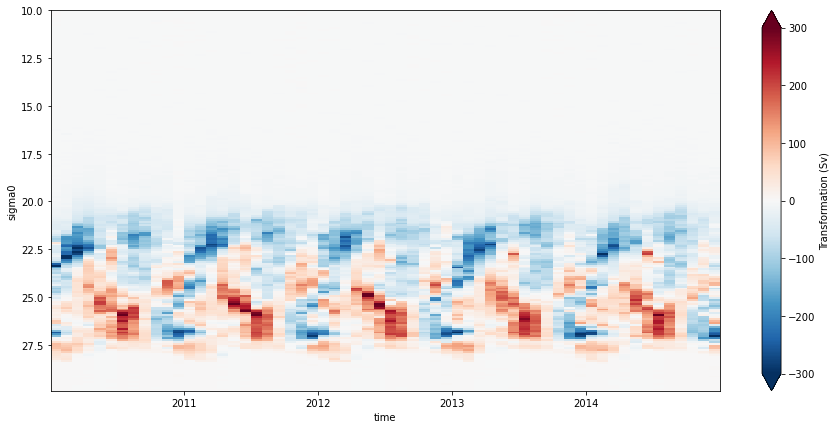

In [14]:
with ProgressBar():
    (G*1e-6).T.plot(figsize=(15,7),cmap='RdBu_r',vmin=-300,vmax=300,yincrease=False,
                    cbar_kwargs={'label': 'Transformation (Sv)'})

We can clearly see seasonality in WMT. Let's plot it as a climatology. Since `G` is a xarray Data.Array you can utilize all xarray functionality. For example, we can use `.groupby()` method to calculate a climatology of `G`.

In [15]:
with ProgressBar():
    G_clim = G.groupby('time.month').mean('time').load()

[########################################] | 100% Completed | 51.39 s


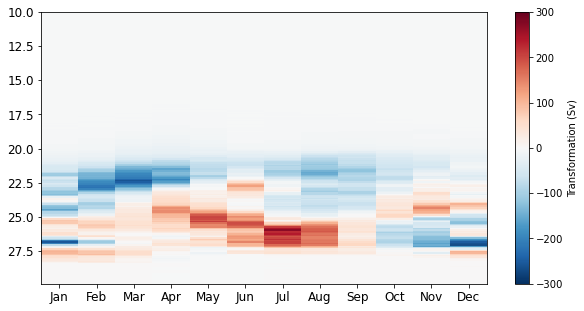

In [16]:
(G_clim*1e-6).T.plot(figsize=(10,5),cmap='RdBu_r',vmin=-300,vmax=300, yincrease=False, add_labels=False,
                     cbar_kwargs={'label': 'Transformation (Sv)'})
plt.xticks(np.arange(1,13))
plt.setp(plt.gca(), 'xticklabels',calendar.month_abbr[1:13])
plt.gca().tick_params(axis='both', which='major', labelsize=12)
plt.show()

Globally, we see densification at higher densities ($\sigma_0$ > 24 kg m$^{-3}$) mostly between May to August and lightenting of waters at lower densities ($\sigma_0$ < 24 kg m$^{-3}$), especially from February and March. Finally, let's look at the mean WMT along $\sigma_0$ and compare it to WMT estimates from ECCOv4 and ERA5. 

In [17]:
# Load the corresponding WMT datasets (dset) generated from ECCOv4 and ERA5 reanalysis
dset_dir = '/home/Graeme.Macgilchrist/wmt/'
ddict = {}
for dset in ['ecco.ecco','era5.en4']:
    filepath = os.path.join(dset_dir,dset.split('.')[0])
    filename = '-'.join([dset+'.G',lstr,basin_name])+'.nc'
    print('Loading',filename)
    ddict[dset.split('.')[0]] = xr.open_dataset(filepath+'/'+filename)

Loading ecco.ecco.G-sigma0-global.nc
Loading era5.en4.G-sigma0-global.nc


In [18]:
yr_st = str(G.time.dt.year[0].values)
yr_ed = str(G.time.dt.year[-1].values)
lab_str = ' '.join([source_id,experiment_id])+' (%s-%s)'%(yr_st,yr_ed)

In [19]:
with ProgressBar():
    G_mean = G.mean('time').load()

[########################################] | 100% Completed | 50.94 s


In [20]:
ddict_mean = {}
for dset in ddict:
    dset_yr_st = str(ddict[dset].sel(time=slice(yr_st,yr_ed)).time.dt.year[0].values)
    dset_yr_ed = str(ddict[dset].sel(time=slice(yr_st,yr_ed)).time.dt.year[-1].values)
    dset_str = dset.upper()+' (%s-%s)'%(dset_yr_st,dset_yr_ed)
    
    if group_tend:
        da = xr.zeros_like(G_mean)
        for tend in ddict[dset].keys():
            da += ddict[dset].sel(time=slice(yr_st,yr_ed))[tend].mean('time')
        ddict_mean[dset_str] = da
        
    else:
        ddict_mean[dset_str] = ddict[dset].sel(time=slice(yr_st,yr_ed)).mean('time')

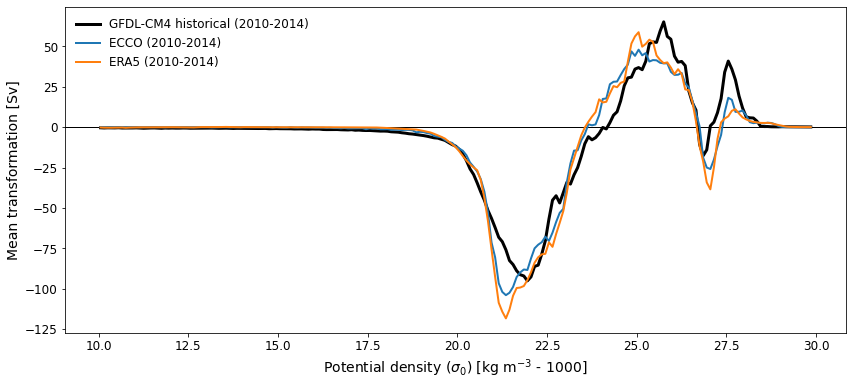

In [21]:
fig, ax = plt.subplots(figsize=(14,6))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(G[lstr], G_mean*1e-6, c='k', lw=3, ls='-',label=lab_str)
for dset in ddict_mean:
    ax.plot(ddict_mean[dset][lstr], ddict_mean[dset]*1e-6, lw=2, linestyle='-', label=dset)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Potential density ($\sigma_0$) [kg m$^{-3}$ - 1000]',fontsize=14)
ax.set_ylabel('Mean transformation [Sv]',fontsize=14)
ax.legend(loc='upper left',frameon=False,fontsize=12)
plt.show()

The global mean picture: Water masses are mostly transformed to denser classes when $\sigma_0$ > 24 kg m$^{-3}$ and to lighter classes when $\sigma_0$ < 24 kg m$^{-3}$. The formation of water masses in $\sigma_0$ is simply the negative differnce of $G$ in $\lambda$-space (i.e., $\Delta G$). $\Delta G$ can be obtained by differentiating the WMT array ($G$) along $\lambda$, or in this case, `sigma0`.

In [22]:
# Surface Formation/Destruction
dG = -1.*G_mean.diff(lstr,label='lower')
dG[lstr] = dG[lstr] + np.diff(G[lstr])/2

In [23]:
dG_ds = dG.to_dataset(name=source_id)

for dset in ddict_mean:
    da = -1.*ddict_mean[dset].diff(lstr,label='lower')
    da[lstr] = da[lstr] + np.diff(ddict_mean[dset][lstr])/2
    dG_ds[dset.split(' ')[0]] = da

In [24]:
# Define bins to plot formation in lambda space
bins = np.arange(lmin,lmax,0.4)

# Center point for each bin (for labeling)
bins_c = (0.5*(bins[1:] + bins[:-1]))

df = dG_ds.groupby_bins(dG_ds[lstr], bins, labels=bins_c).sum(dim=lstr).to_dataframe()*1e-6

In [25]:
from itertools import cycle, islice
my_colors = list(islice(cycle(['k', 'tab:blue', 'tab:orange']), None, len(df)))

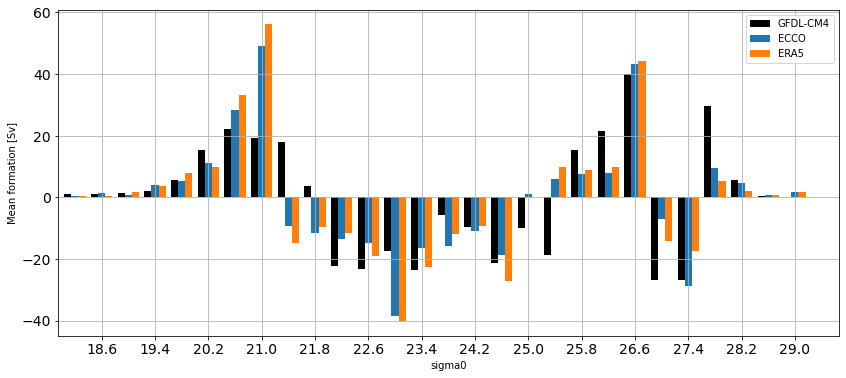

In [26]:
ax = df[(df.index>18)].plot(kind='bar', figsize=(14,6), stacked=False, color=my_colors,
             rot=0, width=0.8, xlabel=lstr,ylabel='Mean formation [Sv]')
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[1::2])
ax.xaxis.set_ticklabels(ticklabels[1::2])
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels([str(round(float(label), 2)) for label in labels])
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(list(dG_ds.keys()))
plt.show()

We see surface water mass formation ocurring at the lightest densities ($\sigma_0$ < 22 kg m$^3$) corresponding to the tropical ocean. The other maxima of surface water mass formation occuring at higher densities ($\sigma_0$ > 25 kg m$^3$) are associated with mode water formation.

We can also decompose $G$ into heat (i.e., thermal) and freshwater/salt (i.e., haline) components. This can be done by setting keyword `group_tend=False` when running `.G()`.

In [27]:
group_tend = False
G = swmt(ds).G(lstr, bins=np.arange(lmin,lmax,dl),group_tend=group_tend)

In [28]:
with ProgressBar():
    G_mean = G.mean('time').load()

[########################################] | 100% Completed | 51.35 s


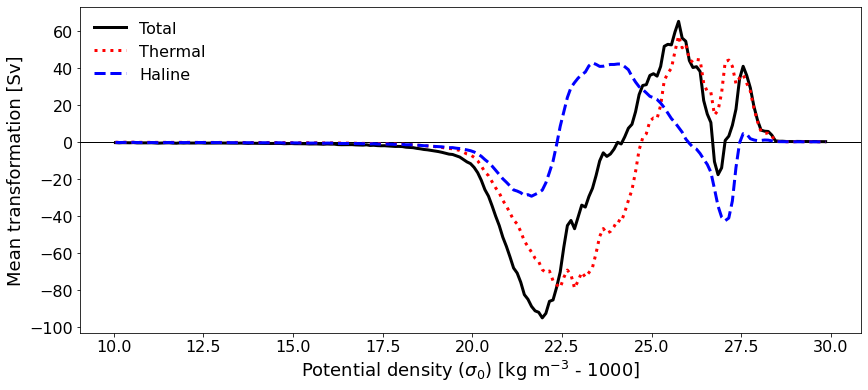

In [29]:
fig, ax = plt.subplots(figsize=(14,6))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(G[lstr], (G_mean.heat+G_mean.salt)*1e-6, color='k', linestyle='-', lw=3, label='Total')
ax.plot(G[lstr], G_mean.heat*1e-6, color='r', linestyle=':', lw=3, label='Thermal')
ax.plot(G[lstr], G_mean.salt*1e-6, color='b', linestyle='--', lw=3, label='Haline')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('Potential density ($\sigma_0$) [kg m$^{-3}$ - 1000]',fontsize=18)
ax.set_ylabel('Mean transformation [Sv]',fontsize=18)
ax.legend(frameon=False, fancybox=False, loc='upper left', ncol=1, fontsize=16)
plt.show()

Here we can see that the haline part is actually counteracting the thermal part in most instances. The thermal part dominates surface WMT in most densities (at a global scale).

Compare to ECCOv4 and ERA5:

In [30]:
ddict_mean = {}
for dset in ddict:
    dset_yr_st = str(ddict[dset].sel(time=slice(yr_st,yr_ed)).time.dt.year[0].values)
    dset_yr_ed = str(ddict[dset].sel(time=slice(yr_st,yr_ed)).time.dt.year[-1].values)
    dset_str = dset.upper()+' (%s-%s)'%(yr_st,yr_ed)
    
    if group_tend:
        da = xr.zeros_like(G_mean)
        for tend in ddict[dset].keys():
            da += ddict[dset].sel(time=slice(yr_st,yr_ed))[tend].mean('time')
        ddict_mean[dset_str] = da
    else:
        ddict_mean[dset_str] = ddict[dset].sel(time=slice(yr_st,yr_ed)).mean('time')

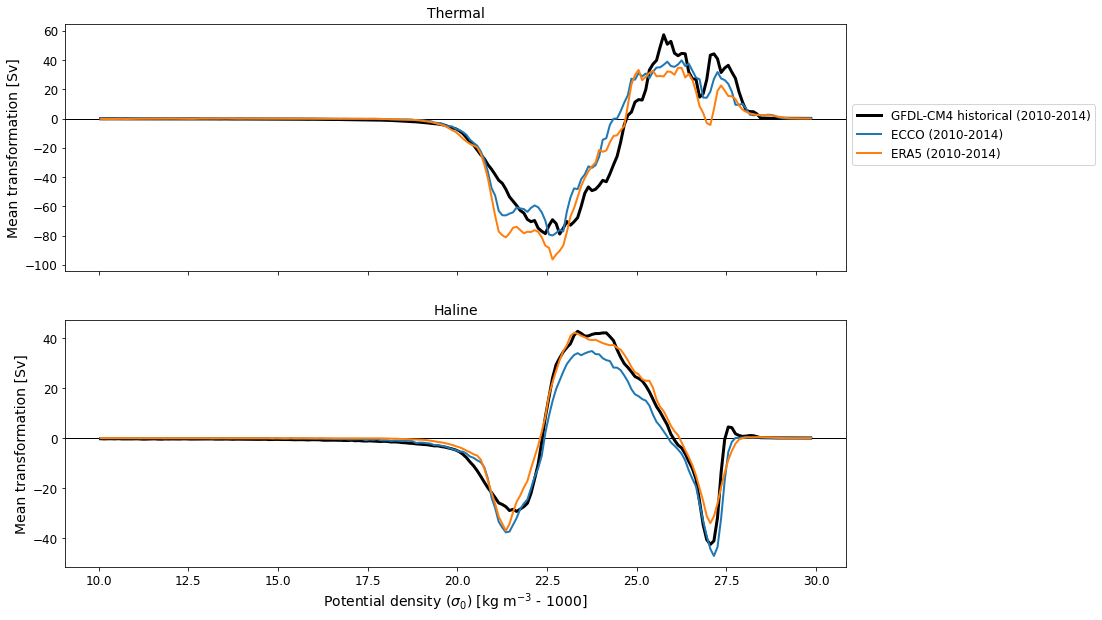

In [31]:
titstr = ['Thermal','Haline']

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(14,10))

for i, ten in enumerate(G_mean.keys()):
    axs[i].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
    axs[i].plot(G[lstr], G_mean[ten]*1e-6, c='k', lw=3, ls='-',label=lab_str)
    for dset in ddict_mean:
        axs[i].plot(ddict_mean[dset][lstr], ddict_mean[dset][ten]*1e-6, lw=2, linestyle='-', label=dset)
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    axs[i].set_ylabel('Mean transformation [Sv]',fontsize=14)
    axs[i].set_title(titstr[i],fontsize=14)
    if i==0:
        axs[i].legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=12)
axs[i].set_xlabel('Potential density ($\sigma_0$) [kg m$^{-3}$ - 1000]',fontsize=14)        
plt.show()

### Regional analysis
We can also focus on a particular region or ocean basin. In that case we need to subset the dataset (`ds`) before initialzing the swmt class. You can define your own region based on some mask or coordinate ranges. However, if you want to compare to available WMT estimates from ECCOv4 and ERA5, the subsampling should be done using the CMIP basin mask. The regional subsetting with the CMIP basin mask uses the mask `basin`, which is included in the dataset `ds`, and setting `basin_name` to any of the following options: *arctic*, *atlantic*, *baltic*, *black*, *global*, *hudson*, *indian*, *mediterranean*, *pacific*, *persian*, *red*, *southern*. In the case of Atlantic (`basin_name = 'atlantic'`) and Pacific (`basin_name = 'pacific'`), reanalysis estimates are also available for the tropical (*atlantic_tropc*, *pacific_tropc*), subtropical (*atlantic_subtN*, *atlantic_subtS*, *pacific_subtN*, *pacific_subtS*) and subpolar regions (*atlantic_subpN*, *pacific_subpN*), based on the following criteria:
```
if basin_name[-6:]=='_tropc':
    mask = mask & (ds["lat"]<=20) & (ds["lat"]>=-20)
if basin_name[-6:]=='_subtN':
    mask = mask & (ds["lat"]<=45) & (ds["lat"]>20)
if basin_name[-6:]=='_subpN':
    mask = mask & (ds["lat"]>45)
if basin_name[-6:]=='_subtS':
    mask = mask & (ds["lat"]>=-45) & (ds["lat"]<-20)
```

Here we show two examples: (1) Southern Ocean (`basin_name = 'southern'`) and (2) Subpolar North Atlantic (`basin_name = 'atlantic_subpN'`).

In [122]:
group_tend = False
basin_name = 'southern'
bidx = [item.split('_')[0] for item in ds.basin.flag_meanings.split(' ')].index(basin_name.split('_')[0])
G = swmt(ds.where(ds.basin==bidx)).G(lstr, bins=np.arange(lmin,lmax,dl),group_tend=group_tend)

da = xr.zeros_like(G[list(G.keys())[0]]).rename('total')
for tend in G.keys():
    da += G[tend]
G['total'] = da

In [89]:
with ProgressBar():
    G_mean = G.mean('time').load()

[########################################] | 100% Completed | 23.03 s


In [90]:
yr_st = str(G.time.dt.year[0].values)
yr_ed = str(G.time.dt.year[-1].values)

In [91]:
# Load the corresponding WMT datasets (dset) generated from ECCOv4 and ERA5 reanalysis
ddict = {}
for dset in ['ecco.ecco','era5.en4']:
    filepath = os.path.join(dset_dir,dset.split('.')[0])
    filename = '-'.join([dset+'.G',lstr,basin_name])+'.nc'
    print('Loading',filename)
    dset_ds = xr.open_dataset(filepath+'/'+filename).sel(time=slice(yr_st,yr_ed))
    
    da = xr.zeros_like(dset_ds[list(dset_ds.keys())[0]]).rename('total')
    for tend in dset_ds.keys():
        da += dset_ds[tend]
        
    dset_ds['total'] = da
    ddict[dset.split('.')[0]] = dset_ds.mean('time')

Loading ecco.ecco.G-sigma0-southern.nc
Loading era5.en4.G-sigma0-southern.nc


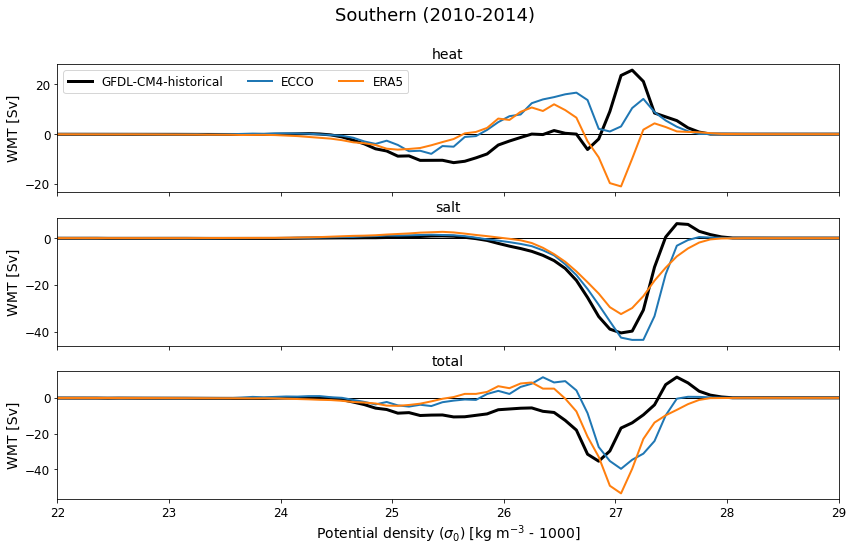

In [102]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(14,8))

for i, ten in enumerate(G_mean.keys()):
    axs[i].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
    axs[i].plot(G[lstr], G_mean[ten]*1e-6, c='k', lw=3, ls='-',label='-'.join([source_id,experiment_id]))
    for dset in ddict:
        axs[i].plot(ddict[dset][lstr], ddict[dset][ten]*1e-6, lw=2, linestyle='-', label=dset.upper())
        
    axs[i].set_xlim([22,29])
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    axs[i].set_ylabel('WMT [Sv]',fontsize=14)
    axs[i].set_title(ten,fontsize=14)
    if i==0:
        axs[i].legend(loc='upper left',ncol=3,fontsize=12)
axs[i].set_xlabel('Potential density ($\sigma_0$) [kg m$^{-3}$ - 1000]',fontsize=14)

fig.suptitle(basin_name.capitalize()+' (%s-%s)'%(yr_st,yr_ed),fontsize=18)
plt.show()

We can see more disagreemnet between the model and reanalysis. Especially, the WMT over the high-end density range is much larger in the model compared to the ranalysis estimates. The haline contribution is much reduced in the reanalysis estimates, likely linked to missing effect of brine rejection from sea ice formation.

To get a better idea of this process, we can use `xwmt` to map WMT per unit area over the Southern Ocean, corresponding to given isopycnal surface. We look at surface WMT across the isopycnal corresponding to the maximum WMT in the high-end density range.

In [100]:
sig_max = np.round(G_mean.total[G_mean.total.argmax()][lstr].values,2)
G_max = np.round(G_mean.total[G_mean.total.argmax()].values*1e-6,2)

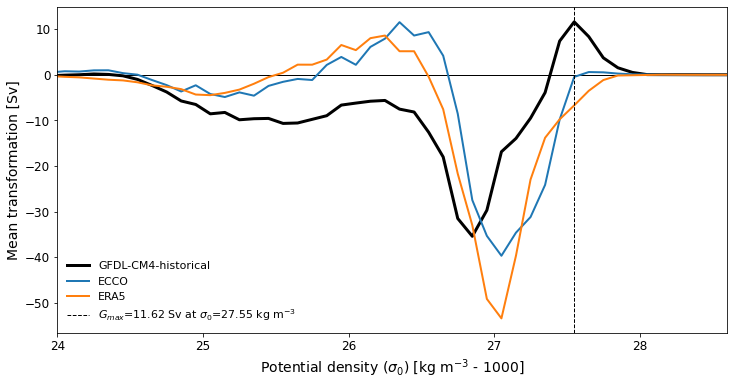

In [108]:
fig, ax = plt.subplots(figsize=(12,6))

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(G[lstr], G_mean.total*1e-6, c='k', lw=3, ls='-',label='-'.join([source_id,experiment_id]))
for dset in ddict:
    ax.plot(ddict[dset][lstr], ddict[dset].total*1e-6, lw=2, linestyle='-', label=dset.upper())
ax.axvline(x=sig_max, c = 'k', ls='--', lw=1, 
           label=r'$G_{max}$=%.2f Sv at $\sigma_%s$=%.2f kg m$^{-3}$'%(G_max,lstr[-1],sig_max))
ax.set_xlim([24,28.6])
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(loc='lower left', ncol=1, fontsize=11,frameon=False)
ax.set_xlabel('Potential density ($\sigma_0$) [kg m$^{-3}$ - 1000]',fontsize=14)
ax.set_ylabel('Mean transformation [Sv]',fontsize=14)
plt.show()

 The maximum WMT in CM4 over the Southern Ocean occurs at $\sigma_0=27.55$ kg m$^{-3}$. We will use `.isosurface_mean()` with input parameter `'sigma0'` (defins what variable is used as $\lambda$), `27.55` (the value of the isosurface, here isopyncal) and `dl = 0.1` ($\Delta\lambda$). This will provide a spatiotemporal filed (`F`) of trasnformation across the isopycnal defined by $\sigma_0=27.55$.

In [110]:
F = swmt(ds.where(ds.basin==bidx,drop=True)).isosurface_mean('sigma0', 27.55, dl = 0.1)

/nbhome/jet/miniconda3/envs/test/lib/python3.9/site-packages/xgcm/grid.py:965: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/nbhome/jet/miniconda3/envs/test/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/nbhome/jet/miniconda3/envs/test/lib/python3.9/site-packages/xgcm/grid.py:965: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/nbhome/jet/miniconda3/envs/test/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be g

In [113]:
with ProgressBar():
    F_mean = F.reset_coords(drop=True).load()

[########################################] | 100% Completed | 23.85 ss


In [114]:
import cmocean.cm as cmo
import cartopy
import matplotlib.path as mpath

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

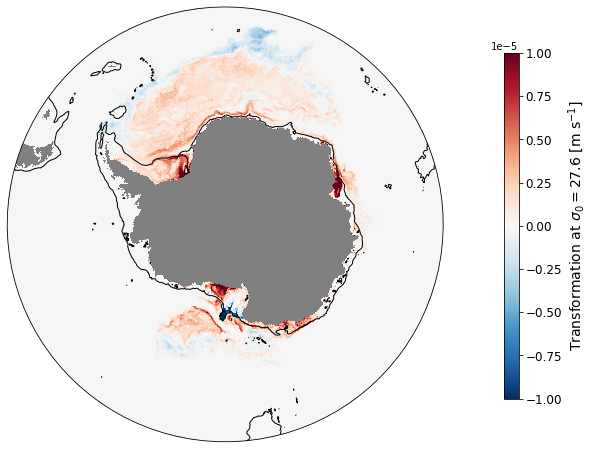

In [117]:
fig = plt.figure(figsize=[10,8])
ax = plt.axes(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),facecolor='grey')
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-300, 60, -50, -90], cartopy.crs.PlateCarree())
p = F_mean.where(ds.wet==1)\
        .plot(ax=ax, x='x', y='y', vmin=-1e-5, vmax=1e-5, cmap='RdBu_r',
              transform=cartopy.crs.PlateCarree(), add_labels=False, add_colorbar=False)
ds.deptho.plot.contour(ax=ax, x='x', y='y', levels=[1000.0], linewidths=1, colors='k', 
                       transform=cartopy.crs.PlateCarree(), add_labels=False)

cax = fig.add_axes([0.9, 0.2 , 0.02, 0.6])
cb = fig.colorbar(p, cax=cax, orientation='vertical', shrink=0.5, pad=0.2)
cb.set_label('Transformation at $\sigma_%s=%.1f$ [m s$^{-1}$]'%(lstr[-1],sig_max), fontsize=14)
cb.ax.tick_params(labelsize=12)
plt.show()

As we can see, the transformation across the dense isopycnal $\sigma_0=27.55$ is mostly occuring over the Antarctic shelf and associated with brine rejection due to sea ice formation.

Now let's compare this to the subpolar North Atlantic regions.

In [126]:
basin_name = 'atlantic_subpN'
bidx = [item.split('_')[0] for item in ds.basin.flag_meanings.split(' ')].index(basin_name.split('_')[0])

In [127]:
mask = ds.basin==bidx

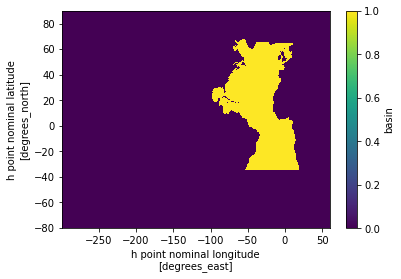

In [128]:
mask.plot()

In [129]:
if basin_name[-6:]=='_tropc':
    mask = mask & (ds["lat"]<=20) & (ds["lat"]>=-20)
if basin_name[-6:]=='_subtN':
    mask = mask & (ds["lat"]<=45) & (ds["lat"]>20)
if basin_name[-6:]=='_subpN':
    mask = mask & (ds["lat"]>45)
if basin_name[-6:]=='_subtS':
    mask = mask & (ds["lat"]>=-45) & (ds["lat"]<-20)

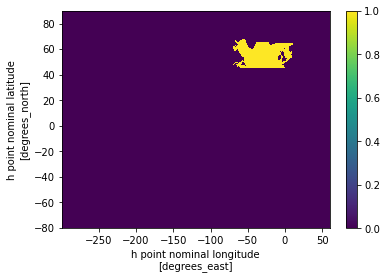

In [130]:
mask.plot()

In [131]:
G = swmt(ds.where(mask,drop=True)).G(lstr, bins=np.arange(lmin,lmax,dl),group_tend=group_tend)
da = xr.zeros_like(G[list(G.keys())[0]]).rename('total')
for tend in G.keys():
    da += G[tend]
G['total'] = da

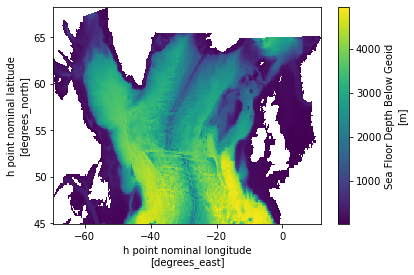

In [134]:
swmt(ds.where(mask,drop=True)).ds.deptho.plot()

In [135]:
with ProgressBar():
    G_mean = G.mean('time').load()

[########################################] | 100% Completed | 7.87 ss


In [136]:
# Load the corresponding WMT datasets (dset) generated from ECCOv4 and ERA5 reanalysis
ddict = {}
for dset in ['ecco.ecco','era5.en4']:
    filepath = os.path.join(dset_dir,dset.split('.')[0])
    filename = '-'.join([dset+'.G',lstr,basin_name])+'.nc'
    print('Loading',filename)
    dset_ds = xr.open_dataset(filepath+'/'+filename).sel(time=slice(yr_st,yr_ed))
    
    da = xr.zeros_like(dset_ds[list(dset_ds.keys())[0]]).rename('total')
    for tend in dset_ds.keys():
        da += dset_ds[tend]
        
    dset_ds['total'] = da
    ddict[dset.split('.')[0]] = dset_ds.mean('time')

Loading ecco.ecco.G-sigma0-atlantic_subpN.nc
Loading era5.en4.G-sigma0-atlantic_subpN.nc


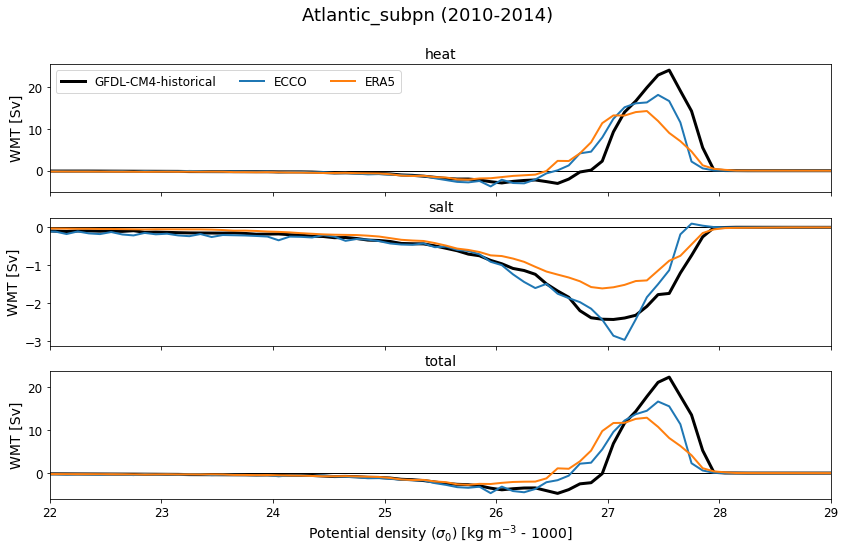

In [137]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(14,8))

for i, ten in enumerate(G_mean.keys()):
    axs[i].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
    axs[i].plot(G[lstr], G_mean[ten]*1e-6, c='k', lw=3, ls='-',label='-'.join([source_id,experiment_id]))
    for dset in ddict:
        axs[i].plot(ddict[dset][lstr], ddict[dset][ten]*1e-6, lw=2, linestyle='-', label=dset.upper())
        
    axs[i].set_xlim([22,29])
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    axs[i].set_ylabel('WMT [Sv]',fontsize=14)
    axs[i].set_title(ten,fontsize=14)
    if i==0:
        axs[i].legend(loc='upper left',ncol=3,fontsize=12)
axs[i].set_xlabel('Potential density ($\sigma_0$) [kg m$^{-3}$ - 1000]',fontsize=14)

fig.suptitle(basin_name.capitalize()+' (%s-%s)'%(yr_st,yr_ed),fontsize=18)
plt.show()

There is more agreement in the WMT estimates between the model and reanalysis datasets. We can also see that WMT is largely due to heat fluxes. Surface waters are being densified over the subpolar North Atlantic due to ocean heat loss with surface freshwater fluxes only slightly counteracting this densification due to a net freshening.

Let's find the isopycnal value associated with the maximum WMT.

In [138]:
sig_max = np.round(G_mean.total[G_mean.total.argmax()][lstr].values,2)
G_max = np.round(G_mean.total[G_mean.total.argmax()].values*1e-6,2)

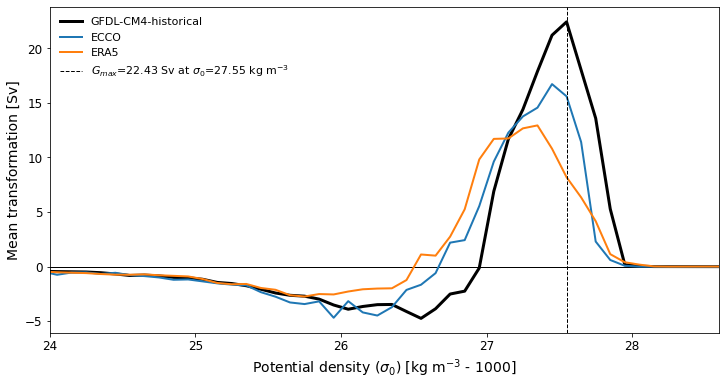

In [140]:
fig, ax = plt.subplots(figsize=(12,6))

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(G[lstr], G_mean.total*1e-6, c='k', lw=3, ls='-',label='-'.join([source_id,experiment_id]))
for dset in ddict:
    ax.plot(ddict[dset][lstr], ddict[dset].total*1e-6, lw=2, linestyle='-', label=dset.upper())
ax.axvline(x=sig_max, c = 'k', ls='--', lw=1, 
           label=r'$G_{max}$=%.2f Sv at $\sigma_%s$=%.2f kg m$^{-3}$'%(G_max,lstr[-1],sig_max))
ax.set_xlim([24,28.6])
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(loc='upper left', ncol=1, fontsize=11,frameon=False)
ax.set_xlabel('Potential density ($\sigma_%s$) [kg m$^{-3}$ - 1000]'%lstr[-1],fontsize=14)
ax.set_ylabel('Mean transformation [Sv]',fontsize=14)
plt.show()

Interestingly, the density value at which WMT in CM4 over the subpolar North Atlantic is at its maximum is also $\sigma_0=27.55$ kg m$^{-3}$ (same as in the Southern Ocean). Lastly, let's look at where most of the transformation occurs by mapping the trasnformation across $\sigma_0=27.55$.

In [141]:
F = swmt(ds.where(mask,drop=True)).isosurface_mean(lstr, 27.55, dl = 0.1)

/nbhome/jet/miniconda3/envs/test/lib/python3.9/site-packages/xgcm/grid.py:965: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/nbhome/jet/miniconda3/envs/test/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/nbhome/jet/miniconda3/envs/test/lib/python3.9/site-packages/xgcm/grid.py:965: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/nbhome/jet/miniconda3/envs/test/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be g

In [142]:
with ProgressBar():
    F_mean = F.reset_coords(drop=True).load()

[########################################] | 100% Completed | 8.39 sms


In [144]:
from matplotlib.offsetbox import AnchoredText

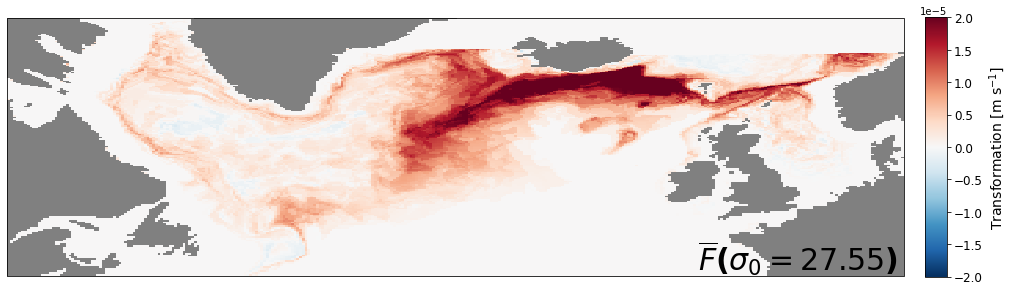

In [164]:
fig = plt.figure(figsize=(15,6))
fig.subplots_adjust(left=0.05, right=0.88, bottom=0.1, top=0.9, hspace=0.01)

ax = plt.axes(projection=cartopy.crs.PlateCarree(),facecolor='grey')
p = F_mean.where(ds.wet==1).plot(ax=ax, x='x', y='y', vmin=-2e-5, vmax=2e-5, cmap='RdBu_r',
                            transform=cartopy.crs.PlateCarree(), add_colorbar=False,add_labels=False)
#ax.set_extent([-75, 47, 48, 88], cartopy.crs.PlateCarree())
ax.add_artist(AnchoredText('$\overline{F}$($\sigma_%s=%.2f$)'%(lstr[-1],sig_max),loc='upper left', 
                           prop={'size': 30, 'weight': 'bold'}, frameon=False,
                           bbox_to_anchor=(0.74, 0.25), bbox_transform=ax.transAxes))
cax = fig.add_axes([0.9, 0.2 , 0.02, 0.6])
cb = fig.colorbar(p, cax=cax, orientation='vertical', shrink=0.5, pad=0.2)
cb.set_label('Transformation [m s$^{-1}$]', fontsize=14)
cb.ax.tick_params(labelsize=12)

plt.show()